# Final Project: Fake News Detection

By Felix Daubner - Hochschule der Medien

Module 'Supervised and Unsupervised Learning' - Prof. Dr.-Ing. Johannes Maucher

## Data Understanding

The data understanding section focuses on getting insights into the scraped data. 
As the scraping process was defined in the previous section, some basic knowledge of the data already exists.
It is already known that the data consists of statements, the overarching topic, the person making the statement as well as the channel the statement was made on and their respective truth classification.

Furhter insights, like distributions, word clouds and correlations are examined in the following.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import wordcloud
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
def textForWordCloud(data, column):
    '''
    Gets a dataframe and joins all data of given column to a single string. Returns string.
    '''
    return " ".join(i for i in data[column])

def createWordCloud(wc, title):
    '''
    Creates and shows wordcloud given a wordcloud object.
    '''
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off') 
    plt.title(title, fontsize=20)
    plt.show()

truth_order = ["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"]
color_order = ["#FF0900", "#FF5B00", "#FFBD44", "#F1FF22", "#00FF08", "#058000"]

def prepareDistChart(data, column, content):
    '''
    Takes a dataframe, column and list. Prepares the dataframe in a way that for each entity of 'column' 
    which are in 'content' the sum of 'truth' classification is computed. 
    After that, it also computes the share of truth classification per entity of 'column' given the total number of occurrences of entity in 'column'.
    Returns prepared dataframe.
    '''
    data_grouped = data[data[column].isin(content)].groupby([column, "truth"]).size().reset_index()
    data_grouped.columns = [column, "truth", "count"]

    data_grouped_sorted = data_grouped.sort_values("truth")

    data_grouped_sorted["total"] = data_grouped_sorted.groupby(column)["count"].transform("sum")
    data_grouped_sorted["relative"] = data_grouped_sorted["count"] / data_grouped_sorted["total"]

    return data_grouped_sorted

def showDistChart(data, column):
    '''
    Gets prepared dataframe and name of column to be visualized. 
    Creates a bar chart where the entities of 'column' are on the y-axis and the 'relative' of every entity on the x-axis.
    Colors indicate the truth classification.
    Returns altair Chart object.
    '''

    data["truth"] = pd.Categorical(data["truth"])

    return alt.Chart(data).mark_bar().encode(
        x="relative",
        y=column,
        color=alt.Color("truth", scale=alt.Scale(domain=truth_order, range=color_order), sort=truth_order) #sort=alt.SortField("order", "ascending")
    ).properties(
        title=f"Distribution of statement classification by {column}",
        width=600,
        height=800
    )

To start the data understanding process, the previously scraped data is imported as a pandas DataFrame.

In [3]:
data = pd.read_csv("data/scraped.csv", sep=";", index_col=0)

The DataFrame consists of five columns: 'statement', 'issue', 'person', 'channel' and 'truth'.

As seen in the output, in 'statement' contains the political statements which were made by the person specified in 'person'. 'issue' contains the context, the statement made on. 'channel' specifies where or how the statement was made, for e.g. on social media, in an interview or press conference. Finally, 'truth' containing the classification of truth which was done by [POLITIFACT.com](https://www.politifact.com/).

Currently, what stands out is that 'statement' and 'channel' are not standardized. 'statement' currently is of datatype string. 'channel' has a variety of expressions for the same channel such as 'in an X post', 'in X, formerly Twitter' or 'in a post on X'. This challenge needs to be taken in the next step, data preprocessing.

In [4]:
data.head(10)

statement                  issue  \
0  Says Sen. Bob Casey, D-Pa., “is trying to chan...  2024-senate-elections   
1  Says the election results are suspicious becau...  2024-senate-elections   
2  A “ballot dump” around 4 a.m. in Milwaukee sho...  2024-senate-elections   
3  “Kari Lake is threatening Social Security and ...  2024-senate-elections   
4  Republican Senate candidate Sam Brown “wants t...  2024-senate-elections   
5  Says opponent Eric Hovde “opposes efforts to n...  2024-senate-elections   
6  “Jacky Rosen voted to allow biological men to ...  2024-senate-elections   
7  “In Montana, we cherish our public lands. But ...  2024-senate-elections   
8  Sen. Bob Casey "has voted in lockstep with his...  2024-senate-elections   
9  "Ruben Gallego wanted to defund the police. He...  2024-senate-elections   

                 person                  channel        truth  
0             Elon Musk             in an X post        false  
1            Eric Hovde   in X, formerly Twitter        false  
2       Instagram posts     in an Instagram post   pants-fire  
3             WinSenate         in a Facebook ad    half-true  
4  Make the Road Nevada             in an X post    half-true  
5         Tammy Baldwin             in TV debate  barely-true  
6             Sam Brown             in an X post        false  
7            Jon Tester           in a post on X        false  
8        Dave McCormick              in a debate        false  
9             Kari Lake    in a press conference        false

In [5]:
data.tail(10)

statement    issue  \
16916  "Hypocrisy at the Clinton Foundation: Top male...  workers   
16917  Says "Elizabeth Warren lied when she says I wa...  workers   
16918  "Closing our state’s wage gap would make a $9 ...  workers   
16919  Says $15-an-hour proposal in Cleveland is "the...  workers   
16920  "There's only three countries in the entire wo...  workers   
16921  Missouri "is the state with the lowest paid wo...  workers   
16922  "In 2009 … Hillary Clinton was at the State De...  workers   
16923  Says Bernie Sanders "fundamentally changed the...  workers   
16924  "We work longer hours than any people in the i...  workers   
16925  Says she will "work to raise the federal minim...  workers   

                person                                            channel  \
16916     Donald Trump                               in an Instagram post   
16917     Donald Trump                                         in a tweet   
16918     Chris Koster                                         in a tweet   
16919        Joe Roman                          in a Plain Dealer article   
16920     Alan Grayson                               in an Orlando debate   
16921       Kiki Curls   in following a Missouri Senate Budget Committ...   
16922         Lee Camp                in an episode of "Redacted Tonight"   
16923   Bernie Sanders                                        in a TV ad    
16924   Bernie Sanders                                       in a speech.   
16925  Hillary Clinton                   in a column posted on Medium.com   

             truth  
16916    half-true  
16917  barely-true  
16918  mostly-true  
16919         true  
16920    half-true  
16921    half-true  
16922    half-true  
16923    half-true  
16924  barely-true  
16925    half-true

The dataset consists of 16926 rows. Each row represent one single statement including metadata.

In [6]:
data.shape

(16926, 5)

Currently, all columns are of datatype 'string'. 

Column 'truth' is going to be mapped to boolean values (0 and 1) in the scope of this project. Column 'issue' is categorical, same goes for 'channel'. 'channel' is also standing out as it is the only column missing some values. This could be due to either an error when scraping the website or because the channel the statement was made was not known or specified by [POLITIFACT.com](https://www.politifact.com/). The handling of those missing values shall be done in the next section, [data preprocessing](04_data-preprocessing.ipynb). Most importantly, the target variable 'truth' is complete, not missing single value meaning the whole dataset can be used for training the model.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16926 entries, 0 to 16925
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  16926 non-null  object
 1   issue      16926 non-null  object
 2   person     16926 non-null  object
 3   channel    16851 non-null  object
 4   truth      16926 non-null  object
dtypes: object(5)
memory usage: 793.4+ KB


The target variable of our machine learning model is 'truth'. 

'truth' contains the classification of statements done by [POLITIFACT.com](https://www.politifact.com/). Each statement is checked and evaluated to determine whether it is 'true', 'mostly-true', ‘half-true', 'barely-true', 'false' or, at worst, 'pants-fire'. 

When printing all characteristics of 'truth' occurring in the dataset, there are more than the named ones. Additionally, 'half-flip', 'full-flop' and 'no-flip' appear. As stated on [POLITIFACT.com](https://www.politifact.com/) those are no truth classifications and there have to be dropped from the dataset.

In [8]:
data["truth"].unique().tolist()

['false',
 'pants-fire',
 'half-true',
 'barely-true',
 'mostly-true',
 'true',
 'half-flip',
 'full-flop',
 'no-flip']

As seen by the ouput of the previous cell, additionally to the already named truth classification there are even more key words like 'half-flip', 'full-flop', and 'no-flip'.

Those keywords are not relevant for the scope of this project as they indicate whether a person has changed their beliefs based on previously made statements.
So for the following analysis, 'half-flip', 'full-flop', and 'no-flip' are not considered. Also, this point will again be part of data preprocessing.

In [9]:
flip = ["full-flop", "half-flip", "no-flip"]

data_drop_flip = data[~data["truth"].isin(flip)]

data_drop_flip["truth"].unique().tolist()

['false', 'pants-fire', 'half-true', 'barely-true', 'mostly-true', 'true']

To get a deeper understanding of the target variable 'truth', the distribution of all the classification is visualized.

The distribution of truth classification is seen below. There is one point which stands out.

As seen in the chart, 'false' occurs by far the most frequently. The second place is 'barely-true' with not even half of the amount of statements being classified as compared to 'false'. 'true' is actually the classification appearing the least. This has to be considered when training the machine learning model. This inequality of distribution can implement a bias into the model.

Also, to be able to use the data for training a machine learning model, the truth classification have to be numerical values. To simplify the classification task, the model should only predict whether a statement was 'true' or 'false'. So instead of training a model to make a multi-class prediction, the output should be binary. Thus, the target variable has to be binarized meaning the 'truth' can be converted into boolean. All ratings in between true and false have to be assigned to one group. This step is going to part of preprocessing and will not be discussed further in data understanding.

In [10]:
alt.Chart(data_drop_flip).mark_bar().encode(
    x = alt.X("truth", sort=alt.Sort(field="count()", order="ascending")),
    y = "count()"
).properties(
    title="Distribution of 'truth'",
    width = 400,
    height = 600
)

alt.Chart(...)

After getting to know 'truth', 'statement' is to be analysed. 

As the content of 'statement' are strings, no numerical analysis can be done yet. Instead, the distribution of length of the statements shall be visualized. Also, word clouds should be created to gain more insights into the statements. A possible correlation of appearing words depending on the value in 'truth' should be done.

In [11]:
data_statements = data_drop_flip["statement"].apply(len).reset_index()
data_statements.columns = ["row", "characters"]

data_statements_index = data_statements.set_index("row")
data_statements_index["truth"] = data["truth"]

data_statements_noflip = data_statements_index[~data_statements_index["truth"].isin(flip)]

In [12]:
alt.Chart(data_statements_noflip).mark_bar().encode(
    x = alt.X("characters", bin=alt.Bin(step=25), title="Number of characters per statement"),
    y = "count()"
).properties(
    title="Distribution of statement length",
    width = 400,
    height = 600,
)

alt.Chart(...)

The number of characters per statement is not considered an important feature to predict whether a statement is either true or false. Still, the next insights should present the distribution of 'truth' depending on statement length. It is assumend that statements which are classified as 'false' contain less characters than statements classified as 'true'. This assumption is based on the thought that true statements contain more information and facts which contribute to extend the statements while false statements are just claims without further context nor supported by facts.

In [13]:
data_statements_noflip[data_statements_noflip["truth"]=="false"]["characters"].describe()

count    6115.000000
mean       99.504988
std        40.732692
min        21.000000
25%        70.000000
50%        92.000000
75%       122.000000
max       348.000000
Name: characters, dtype: float64

In [14]:
data_statements_noflip[data_statements_noflip["truth"]=="true"]["characters"].describe()

count    1438.000000
mean      109.506259
std        44.813209
min        26.000000
25%        77.000000
50%       100.500000
75%       135.000000
max       310.000000
Name: characters, dtype: float64

The assumption that statements classified as 'false' contain less characters than statements classified as 'true' can be confirmed. Falsly classified statements contain on average 99 characters while truely classified statements contain on average 109 characters. The median of both type of statements also back up the fact that true statements contain more words than false statements. However, the difference in the average is only ten characters which might add up to about one or two words.

Now, word clouds are created. A word cloud visualizes the words of a text in different sizes depending on the number of occurrences. Words which appear more often are shown in a bigger font than words which appear less frequent. This gives insights in words which are often used in political statements.

A problem which already has to be addressed are so-called 'stop words' like 'and', 'or', 'is' or 'are' which appear quite often as they are fundamental to every sentence. However, those words do not contain any information. To only use the relevant words, all these stop words are eliminated from the word cloud. Based on some manually read statements, some more words and even characters are excluded from the word cloud.

In [15]:
stopwords = wordcloud.STOPWORDS
stopwords.update(["Say", "will", "Says", "U", "S", "US"])

In [16]:
statements = textForWordCloud(data_drop_flip, "statement")

The first word cloud covers all statements of the dataset regardless of 'issue', 'person', 'channel', or 'truth'.

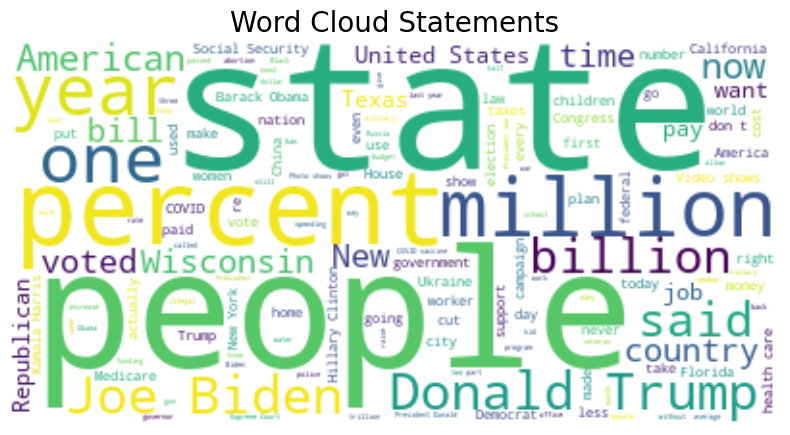

In [17]:
wcloud = wordcloud.WordCloud(background_color="white").generate(statements)

createWordCloud(wcloud, "Word Cloud Statements")

The words appearing most often are 'state' and 'people'. As only political statements are handled in this project, the frequent occurrences of those words is explained easily. To address their statements, politicians often speak of either 'people' or 'state'. Other words standing out are 'percent', 'million', 'year', 'American', 'now', 'country' as well as the names of current US president 'Joe Biden' and president-to-be 'Donald Trump'. 

Now, two word clouds of only 'true' and only 'false' statements are visualized and compared. Those word clouds might already provide some insights into the wording which is used in either type of statements. The assumptions made by comparing those two wordclouds will not be substantiated by studies, but might used as a fundament for further discussions at the end of this project.

In [18]:
facts = textForWordCloud(data_drop_flip[data_drop_flip["truth"].isin(["true"])], "statement")

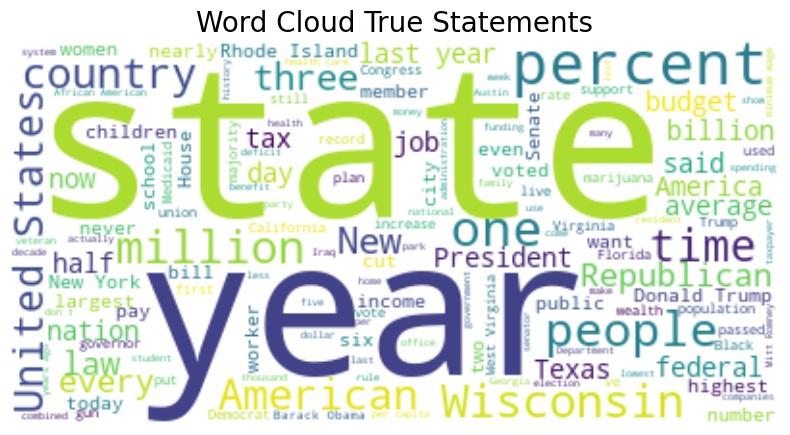

In [19]:
wcloud_facts = wordcloud.WordCloud(background_color="white").generate(facts)

createWordCloud(wcloud_facts, "Word Cloud True Statements")

The word cloud containing only true statements has three words stand out: 'percent', 'year', and 'state'. The words 'year' and 'percent' might indicate a reference to facts and statistics which would fit to the fact that only statements classified as 'true' are considered.

In [20]:
fake = textForWordCloud(data_drop_flip[data_drop_flip["truth"].isin(["false"])], "statement")

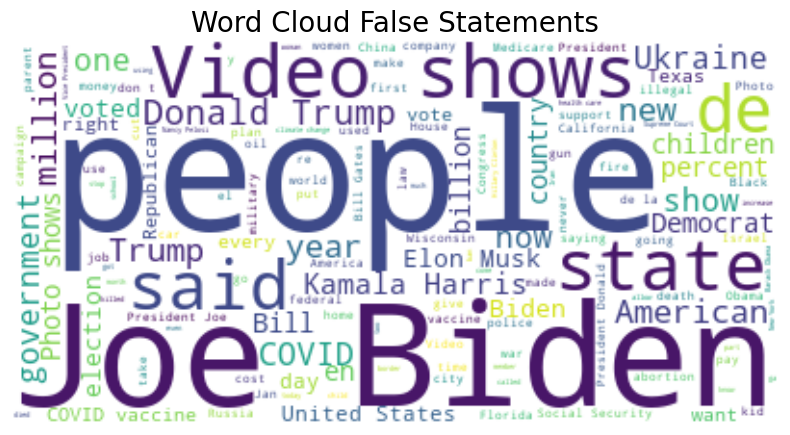

In [21]:
wcloud_fake = wordcloud.WordCloud(background_color="white").generate(fake)

createWordCloud(wcloud_fake, "Word Cloud False Statements")

The word cloud containing only falsely classified statements also has some words standing out, one in particular. The name of current US president 'Joe Biden' appears quite often. Statements which contain his name might want to criticize his decisions and government by making up stories or by consciously adding wrong information. This might be a try to persuade people to turn away from Joe Biden and his administration to probably benefit ones own political agenda.
Also, instead of 'state' the word 'people' appears more frequent which might be due to the addressing of the statements to gain more empathy. Also, 'Video' and 'shows' are popular too. Those two words might appear only together. The frequent occurrence of those words might come from the fact that the source they base their statement on is a video which might be staged or manipulated or even AI generated.

However, there are not that many differences in both word clouds. So only based on the word clouds, there is no possiblity to reliably distinguish between true and false statements, at least manually.

To better understand the data focusing on 'people', 'channel' and 'issue', those features are to be analysed in the following.

Firstly, all issues adressed in the dataset should be list in descending order based on the number statements made on those issues.

In [22]:
data_issue = data_drop_flip["issue"].value_counts().reset_index()
data_issue.columns = ["issue", "count"]

The following chart shows the distribution of all statements across the issues. Nearly half the issues have close to 150 statements which is the upper bound. Those issues are mostly fundamental political issues such as abortion, military, health-care, income, immigration, or housing. However, the issues with less than 150 statements are mostly temporary issues such as katrina (hurricane), 2024 senate elections, or january 6 (US Capitol attack).

In [23]:
alt.Chart(data_issue).mark_bar().encode(
    x = "count",
    y = alt.Y("issue", sort=alt.Sort(field="count", order="descending"))
).properties(
    title="Distribution of 'issue'",
    width = 600,
    height = 1400,
)

alt.Chart(...)

For all issues having 150 count of statements, the distribution of 'truth' within their issue should be visualized.

In [24]:
max_issues = data_issue[data_issue["count"]==150]["issue"].to_list()

The data is prepared in such a way that for each topic, the sum of each classification and the proportion of the classification in the total occurrence of the topic is calculated.

In [25]:
data_issue_grouped = prepareDistChart(data_drop_flip, "issue", max_issues)

For every issue, the share of statements classified in each of the truth classification can be seen in the chart below.
What stands out is that some issues like 'elections', 'facebook-fact-checks', 'russia' and 'ukraine' do not seem to contain a single true statement. Also for nearly every issue, the number of 'false' statements exceeds the number of 'true' statements. This shockingly shows how few statements are 100% correct with most of the statements for each issue classified as 'barely-true'. 

In [26]:
showDistChart(data_issue_grouped, "issue")

alt.Chart(...)

Now all persons making statements shall be listed in a descending order regarding the amount the statements they made.

In [27]:
data_persons = data_drop_flip["person"].value_counts()[:25].reset_index()
data_persons.columns = ["person", "count"]

Even though only real people should be part of the following chart, there are also some channels listed. Currently, it is not clear why this has happened. This might be a problem when scraping the data and has to be addressed in data preprocessing.

Still, there are many 'real' people making statements. The person making the most statements is US president-to-be Donald Trump followed by current US president Joe Biden. Also, some other known people made the list such as Hillary Clinton, former US presidental candidate for the Democratic party, Barack Obama, former US president, or Kamala Harris, current US Vice president. 

In [28]:
alt.Chart(data_persons).mark_bar().encode(
    x = "count",
    y = alt.Y("person", sort=alt.Sort(field="count", order="descending"))
).properties(
    title="Count of statements of 'person'",
    width = 600,
    height = 600,
)

alt.Chart(...)

Now, for every 'real' person, the distribution of truth classification should be looked at. To achieve this, all non-persons have to be eliminated.

In [29]:
persons = data_persons["person"].to_list()

remove = ["Facebook posts", "Instagram posts", "Viral image", "X posts", "TikTok posts", "Threads posts", "Social Media", "Chain email"]
persons_womedia = [i for i in persons if i not in remove]


In [30]:
data_persons_grouped = prepareDistChart(data_drop_flip, "person", persons_womedia)

By comparing persons to each other there is one thing which stands out: people who are part of or associated with the Democratic party are more likely to say statements which are at least "mostly-true" than people who are part of or associated with the Republican party. Same goes the other way around: people who tend to be Democrats are less likely to make statements which are at best 'false' while people who tend to be Republican are more likely to make false statements.

In [31]:
showDistChart(data_persons_grouped, "person")

alt.Chart(...)

Now, the channels are to be analysed in the same way as the issues and persons. At first, the distribution of all channels shall be visualized. After that, for every channel the share of the truth classification is shown and compared.

In [32]:
data_channel = data_drop_flip["channel"].value_counts()[:25].reset_index()
data_channel.columns = ["channel", "count"]

Before interpreting the chart, it stands out that the channels have not been cleaned yet. For e.g. the channels 'in a tweet', 'in Twitter', 'in an X post', 'in a post on X' and partly 'in social media posts' are the same. Now, Twitter or X might be special as it was renamed and some statements might have been examined before the renaming. But same problem applies to Facebook. There are 'in a Facebook post', 'in una publicacion en Facebook' and ' in a post on Facebook' all meaning the same channel.

This also points to another problem. Until here, it was assumed that the language of all statements, channels etc. was English. As seen with channel 'in una publicacion en Facebook', Spanish also occurs. As the machine learning model should only be trained on English statements, this has to be addressed in data preprocessing.

In [33]:
alt.Chart(data_channel).mark_bar().encode(
    x = "count",
    y = alt.Y("channel", sort=alt.Sort(field="count", order="descending"))
).properties(
    title="Count of statements of 'channel'",
    width = 600,
    height = 600,
)

alt.Chart(...)

Not only shall the persons who made a statement be visualized but also the channel the statements were made on regardless of the person.

In [34]:
channel = data_channel["channel"].to_list()

In [35]:
data_grouped_channel = prepareDistChart(data_drop_flip, "channel", channel)

Now, due to the named difficulties it is not easy to interpret this chart. But what stands out are that 'in Twitter', 'in a TV interview', 'in a radio interview', 'in a debate', 'in a news release' and 'in a press release' have the highest percentage of statements being at least 'mostly-true'. This shows that, leaving out 'in Twitter', in official documents as well as in (critical) interviews or debates, statements have higher chance of being true than in every other channel. Looking for e.g. at all the 'Facebook' channels, it stands out that only a little percentage of all statements are classified as true making Facebook a platform of rather false statements.

This already verifies the hypothesis that Social Media has a higher percentage of Fake News than any other channel. Certainly, there are still differences between different Social Media platforms but non-Social Media channels tend to have higher percentage of statements tending to be true.

In [36]:
showDistChart(data_grouped_channel, "channel")

alt.Chart(...)

### Summary

Many insighs were found when digging deeper into the data. 

Especially three points stood out:
1. The wording of false and true statements does not differ much, at least based on manual analysis using word clouds. There are some differences which can be explained but a clear distinction can not be made solely based on the most frequently occurring words.
2. People who are rather associated with the Republican party have a higher percentage of statements which are rather false than Democratic-associated people. Unfortunately, the data does not contain information of political affiliation to a party. Whether this can be used a potential feature for the machine learning model has to be discussed.
3. Social Media channels like Facebook, Twitter/X, TikTok or Instagram do contain a higher percentage of rather false statements than any other kind of channel like ads, press releases, interview, speeches or debates. This backs up the insights which were looked at in [problem understanding](01_problem-understanding.ipynb) as Social Media accelerates the spread of controversial, fake information.